In [3]:
import pyspark 
import matplotlib
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import StructType
from pyspark.sql.functions import *

In [5]:
spark = SparkSession.builder\
	.master("local").appName("bde").getOrCreate()

# mean time to failure as per manufacturer spec, with expected average of 10 parts per million for dust / pm10
mttf=2500
rpm10=10
expected_days=int(mttf/24)
# airfilter installation date -- needs to be input variable?
airfilterdate='2022-03-01 00:00:00'

In [16]:
hdfs_host = ""
hdfs_port = ""
#file path should start with file:///
file_path = ""

In [25]:
schema = StructType() \
                        .add("timestamp","timestamp") \
                        .add("entryid","integer") \
                        .add("PM1_0","double") \
                        .add("PM2_5","double") \
                        .add("PM10","double") \
                        .add("UptimeMinutes","integer") \
                        .add("RSSI_dbm","integer") \
                        .add("Temperature_F","integer") \
                        .add("Humidity_pct","integer") \
                        .add("PM2_5_ATM","double")

df = spark.read.csv(f"{file_path}/ElsiesRiver09_01_2021_05_31_2022.csv", header=False, schema=schema)
df.write.csv(f"hdfs://{hdfs_host}:{hdfs_port}/airquality/ElsiesRiver09_01_2021_05_31_2022.csv")

+-------------------+-------+-----+-----+----+-------------+--------+-------------+------------+---------+
|          timestamp|entryid|PM1_0|PM2_5|PM10|UptimeMinutes|RSSI_dbm|Temperature_F|Humidity_pct|PM2_5_ATM|
+-------------------+-------+-----+-----+----+-------------+--------+-------------+------------+---------+
|2021-09-01 04:25:11| 166999|  0.0|  0.0| 0.0|        14068|     -76|           54|          53|      0.0|
|2021-09-01 04:31:11| 167002|  0.0|  0.0| 0.0|        14074|     -76|           54|          53|      0.0|
|2021-09-01 04:33:11| 167003|  0.0|  0.0| 0.0|        14076|     -76|           54|          53|      0.0|
|2021-09-01 04:37:11| 167005|  0.0|  0.0| 0.0|        14080|     -76|           54|          53|      0.0|
|2021-09-01 06:19:13| 167056|  0.0|  0.0| 0.0|        14182|     -75|           54|          53|      0.0|
|2021-09-01 07:57:14| 167105|  0.0|  0.0| 0.0|        14280|     -76|           54|          53|      0.0|
|2021-09-01 08:05:14| 167109|  0.0|  

In [17]:
aqdata1 = spark.read.format("csv") \
                    .option("header", True) \
                    .option("inferSchema", True) \
                    .load(f"hdfs://{hdfs_host}:{hdfs_port}/airquality/ElsiesRiver09_01_2021_05_31_2022.csv", schema=schema)

In [26]:
# filter the data to only after the airfilter was installed
aqdata=aqdata1.where(aqdata1.timestamp > airfilterdate)

In [19]:
# for testing
pmmindate=aqdata.select(min("timestamp"))
pmmaxdate=aqdata.select(max("timestamp"))
pm10total=aqdata.select(sum("PM10"))
pmperiod=aqdata.select(datediff(max("timestamp"),min("timestamp")))
pmcount=aqdata.select(count("timestamp").alias("pmcount"))
pm10total.show()     
pmperiod.show()
pmcount.show()
pmmindate.show()
pmmaxdate.show()

+------------------+
|         sum(PM10)|
+------------------+
|1089342.8700000036|
+------------------+

+----------------------------------------+
|datediff(max(timestamp), min(timestamp))|
+----------------------------------------+
|                                      91|
+----------------------------------------+

+-------+
|pmcount|
+-------+
|  64867|
+-------+

+-------------------+
|     min(timestamp)|
+-------------------+
|2022-03-01 00:01:53|
+-------------------+

+-------------------+
|     max(timestamp)|
+-------------------+
|2022-05-31 20:11:06|
+-------------------+



+-----------------------+
|AirfilterExpirationDate|
+-----------------------+
|             2022-05-14|
+-----------------------+



<AxesSubplot:xlabel='Date'>

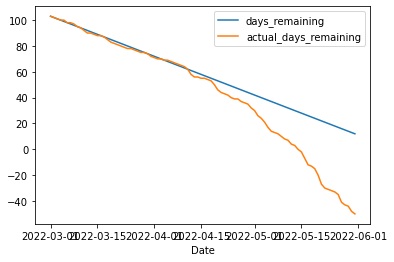

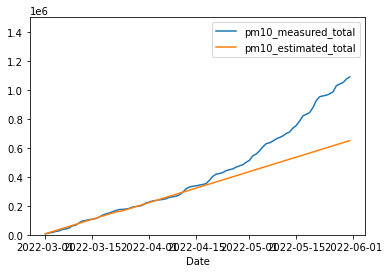

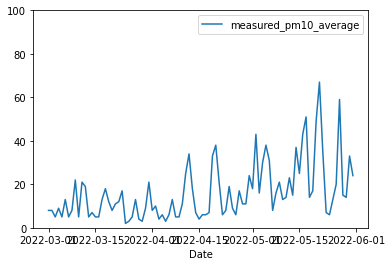

In [32]:
# Do the math
aqdata2=aqdata.groupBy(to_date("timestamp").alias("tdate")).agg(sum("PM10").alias("PM10_SUM"),count("timestamp").alias("num_count"),avg("PM10").alias("PM_10_avg"))

aqdata2=aqdata2.withColumn('estpartPM10',((col('num_count') * lit(10)))).withColumn('estdiff',((col('PM10_SUM') - col('num_count') * lit(10))))
                
aqdata2=aqdata2.orderBy(col("tdate"))
windowSpec=Window.partitionBy().orderBy("tdate")
windowSpec2=Window.partitionBy().orderBy("tdate").rowsBetween(Window.unboundedPreceding,Window.currentRow)
aqdata2=aqdata2.withColumn("days_used",row_number().over(windowSpec))
aqdata2=aqdata2.withColumn("pm10_rolling_total", sum("PM10_SUM").over(windowSpec2)) \
                .withColumn("estpm10_rolling_total", sum("estpartPM10").over(windowSpec2)) \
                .withColumn("estdiff_rolling_total", sum("estdiff").over(windowSpec2))
aqdata2=aqdata2.withColumn("days_remaining", lit(expected_days) - col("days_used"))
aqdata2=aqdata2.withColumn("actual_days_remaining", col("days_remaining") - (col("estdiff_rolling_total")/(col("estpm10_rolling_total")/col("days_used"))))
#aqdata2.show()
aqdata3=aqdata2.select(col("tdate").alias("Date"),col("days_remaining"), \
               col("actual_days_remaining").cast('int'), \
               col("pm10_rolling_total").cast('int').alias("pm10_measured_total"), \
               col("estpm10_rolling_total").cast('int').alias("pm10_estimated_total"), \
               col("PM_10_avg").cast('int').alias("measured_pm10_average")  
               )
aqdata3.filter(aqdata3['actual_days_remaining']==0).select(first(col("Date")).alias("AirfilterExpirationDate")).show()

# plot the graphs
aqdata4=aqdata3.toPandas()
aqdata4.plot(x='Date',y=['days_remaining','actual_days_remaining'])
aqdata4.plot(x='Date',y=['pm10_measured_total','pm10_estimated_total'],ylim=(0,1500000))
aqdata4.plot(x='Date',y='measured_pm10_average',ylim=(0,100))
